In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from collections import Counter

%matplotlib inline

In [160]:
def process_file(file_id=100, nu_cut=1.0, beta=1.0, make_plot=False):

    peak_name = "map{:d}_100deg2_sl2.5_GSN_peaks.txt".format(file_id)
    peak_file = os.path.join("../data/", peak_name)
    all_peak_data = np.loadtxt(peak_file)

    # significance cut
    ii = all_peak_data[:,0]> nu_cut
    peak_data = all_peak_data[ii]

    peak_pos_file = peak_file.replace("map", "pos")
    np.savetxt(peak_pos_file, peak_data[:,1:])

    out_filename = "../data/beta_{:.2f}_nu_{:.2f}_{}".format(beta, nu_cut, peak_name)
    
    skel = "/Users/forero/Applications/ngl-beta/build/binsrc/./getNeighborGraph "

    if not os.path.exists(out_filename):
        cmd = "{} -d 2 -i {} -b {} -o > {}".format(skel, peak_pos_file, beta, out_filename)
        print(cmd)
        os.system(cmd)
    
    # read in the pairs
    point_data = np.loadtxt(peak_pos_file)
    beta_data = np.int_(np.loadtxt(out_filename))

    # remove the duplicate points using the fact that the first column is ordered in ngl-beta
    ii = beta_data[:,0]<beta_data[:,1]
    beta_data = beta_data[ii]

    n_points = len(point_data)
    #print(n_points)

    # Flattend and count links
    beta_data_flat = beta_data.flatten()
    beta_link_count = Counter(Counter(beta_data_flat).values())

    # Count how many points have zero links
    unique_beta_id = len(set(beta_data_flat))
    if (n_points - unique_beta_id)>0:
        beta_link_count[0] = n_points - unique_beta_id

    assert np.sum(list(beta_link_count.values()))==n_points
    # compute probability array
    proba = []
    total_link = np.sum(list(beta_link_count.values()))
    for k in beta_link_count:
        #print(k, beta_link_count[k]/total_link)
        proba.append(beta_link_count[k]/total_link)
    proba = np.array(proba)
    #print(proba, proba.sum())
    entropy = np.sum(-proba*np.log(proba)/np.log10(2))
    #print('Entropy', entropy)
    mean_connections = len(beta_data)/len(point_data)
    #print('Mean connections', mean_connections)

    # compute the distances
    delta_x  = point_data[beta_data[:,0],0] - point_data[beta_data[:,1],0]
    delta_y = point_data[beta_data[:,0],1] - point_data[beta_data[:,1],1]
    distance = np.sqrt(delta_x**2 + delta_y**2)
    #_ = plt.hist(distance)
    normed_mean_distance = np.mean(distance)/np.std(distance)

    # plot the skeleton
    if make_plot:
        title = r"$\beta={:.1f}$, $\nu>{:.1f}$, Entropy={:.2f} Sh, $\langle l\rangle / \sigma_l = {:.2f}$, $\kappa={:.1f}$".format(
            beta, nu_cut, entropy, normed_mean_distance, mean_connections)
        plt.figure(figsize=(8,8))
        for p in beta_data:
            #print(p)
            plt.plot(point_data[p,0], point_data[p,1], c='black')
        plt.scatter(all_peak_data[:,1], all_peak_data[:,2],c=all_peak_data[:,0], alpha=0.8, cmap='tab10')
        #plt.scatter(peak_data[:,1], peak_data[:,2],c='black')
        plt.axis('scaled')
        plt.title(title)
    return {'entropy':entropy, 'mean_dist':normed_mean_distance, 'mean_connections':mean_connections, 
            'beta':beta, 'nu_cut':nu_cut, 'file_id':file_id}

{'beta': 2.0,
 'entropy': 3.172477968235261,
 'file_id': 100,
 'mean_connections': 1.2250396196513471,
 'mean_dist': 1.7923282107925027,
 'nu_cut': 1.5}

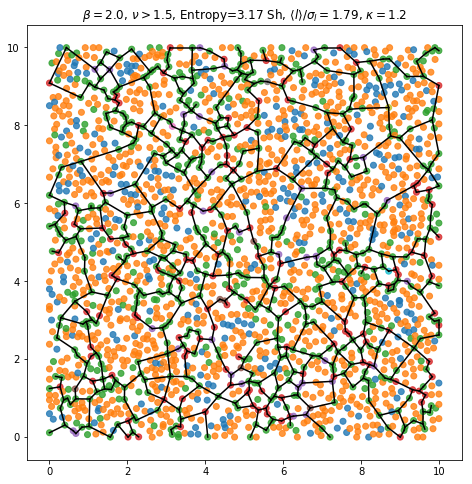

In [161]:
process_file(nu_cut=1.5, beta=2.0, make_plot=True)

{'beta': 2.0,
 'entropy': 3.0767805405160877,
 'file_id': 100,
 'mean_connections': 1.178743961352657,
 'mean_dist': 1.683715739859228,
 'nu_cut': 2.5}

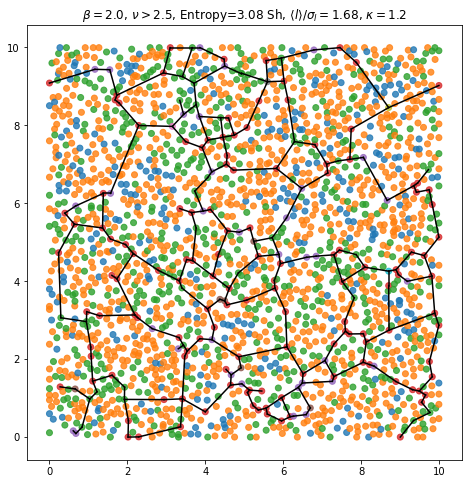

In [162]:
process_file(nu_cut=2.5, beta=2.0, make_plot=True)

{'beta': 2.0,
 'entropy': 3.260649653737184,
 'file_id': 100,
 'mean_connections': 1.103896103896104,
 'mean_dist': 1.6097472267222077,
 'nu_cut': 3.5}

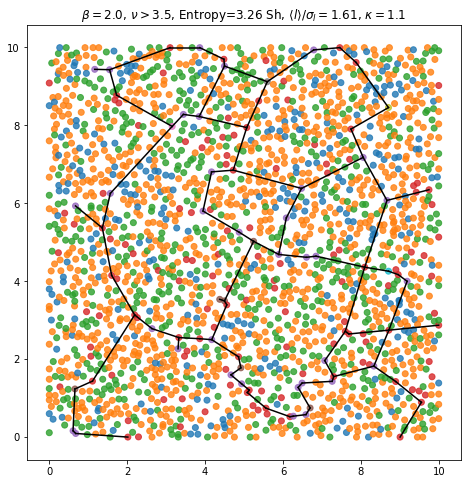

In [163]:
process_file(nu_cut=3.5, beta=2.0, make_plot=True)

In [164]:
beta_values = np.linspace(1.0, 3.0 , 9)
nu_cut_values = np.linspace(1.5, 3.5, 9)
file_id_values = np.arange(10)

outfile = open("../data/summary.txt", "w")
outfile.write("# file_id nu_cut beta entropy mean_dist mean_connections\n")
for file_id in file_id_values:
    for nu_cut in nu_cut_values:
        for beta in beta_values:
            results = process_file(file_id=file_id, nu_cut=nu_cut, beta=beta)
            outfile.write("{:d}\t".format(results['file_id']))
            outfile.write("{:.2f}\t".format(results['nu_cut']))
            outfile.write("{:.2f}\t".format(results['beta']))
            outfile.write("{:.2f}\t".format(results['entropy']))
            outfile.write("{:.2f}\t".format(results['mean_dist']))
            outfile.write("{:.2f}\t".format(results['mean_connections']))

            outfile.write("\n")
outfile.close()

[1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5 ]


In [165]:
dtype=[('file_id', 'i8'), ('nu_cut', 'f8'), ('beta', 'f8'), ('entropy', 'f8'), ('mean_dist', 'f8'), ('mean_connections', 'f8')]
summary_data = np.loadtxt("../data/summary.txt", dtype=dtype)

{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}


Text(0.5,0,'$\\beta$')

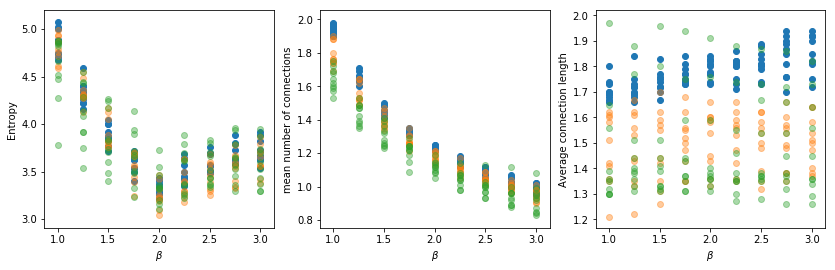

In [166]:
ii = summary_data['nu_cut']==1.5
jj = summary_data['nu_cut']==2.5
kk = summary_data['nu_cut']==3.5

print(set(summary_data['nu_cut']))
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.scatter(summary_data['beta'][ii], summary_data['entropy'][ii])
plt.scatter(summary_data['beta'][jj], summary_data['entropy'][jj], alpha=0.4)
plt.scatter(summary_data['beta'][kk], summary_data['entropy'][kk], alpha=0.4)
plt.ylabel('Entropy')
plt.xlabel(r'$\beta$')

plt.subplot(1,3,2)
plt.scatter(summary_data['beta'][ii], summary_data['mean_connections'][ii])
plt.scatter(summary_data['beta'][jj], summary_data['mean_connections'][jj], alpha=0.4)
plt.scatter(summary_data['beta'][kk], summary_data['mean_connections'][kk], alpha=0.4)
plt.ylabel('mean number of connections')
plt.xlabel(r'$\beta$')

plt.subplot(1,3,3)
plt.scatter(summary_data['beta'][ii], summary_data['mean_dist'][ii])
plt.scatter(summary_data['beta'][jj], summary_data['mean_dist'][jj], alpha=0.4)
plt.scatter(summary_data['beta'][kk], summary_data['mean_dist'][kk], alpha=0.4)
plt.ylabel('Average connection length')
plt.xlabel(r'$\beta$')

{1.5, 2.5, 2.0, 2.25, 1.75, 2.75, 3.0, 3.25, 3.5}


Text(0.5,0,'$\\nu$')

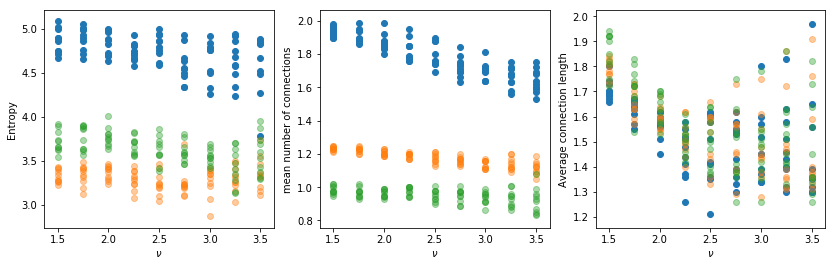

In [167]:
ii = summary_data['beta']==1.0
jj = summary_data['beta']==2.0
kk = summary_data['beta']==3.0

print(set(summary_data['nu_cut']))
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.scatter(summary_data['nu_cut'][ii], summary_data['entropy'][ii])
plt.scatter(summary_data['nu_cut'][jj], summary_data['entropy'][jj], alpha=0.4)
plt.scatter(summary_data['nu_cut'][kk], summary_data['entropy'][kk], alpha=0.4)
plt.ylabel('Entropy')
plt.xlabel(r'$\nu$')

plt.subplot(1,3,2)
plt.scatter(summary_data['nu_cut'][ii], summary_data['mean_connections'][ii])
plt.scatter(summary_data['nu_cut'][jj], summary_data['mean_connections'][jj], alpha=0.4)
plt.scatter(summary_data['nu_cut'][kk], summary_data['mean_connections'][kk], alpha=0.4)
plt.ylabel('mean number of connections')
plt.xlabel(r'$\nu$')

plt.subplot(1,3,3)
plt.scatter(summary_data['nu_cut'][ii], summary_data['mean_dist'][ii])
plt.scatter(summary_data['nu_cut'][jj], summary_data['mean_dist'][jj], alpha=0.4)
plt.scatter(summary_data['nu_cut'][kk], summary_data['mean_dist'][kk], alpha=0.4)
plt.ylabel('Average connection length')
plt.xlabel(r'$\nu$')